This notebook makes the initial plots for the analysis having packed a lot of the functions into spin_bias_funcs.py

Plots include : 
- making average lambda_Re plots for filament sample vs. control
- distributions of Mhalo, overdensity for these samples.

In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kin_morph_funcs as knf
from astropy.cosmology import Planck15
from scipy import interpolate
import scipy.stats as stats
import scipy
import spin_bias_funcs as sbf
import imp
imp.reload(sbf)
from matplotlib import rcParams

sbf.plot_default(rcParams)

#### Loading in relevant catalogues and matching.

In [2]:
# loading in cosmic web catalogues and matching manga ids to get info for all MaNGA targets.
inpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/catalogues/'
outpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/plots/'

mid = pd.read_csv(inpath+'MaNGA_IDs')
cw = pd.read_csv(inpath+'CW_mpl6_yang_s5.csv')#'CW_SDSS_GC1_S3/DR10_MaNGA_matched_S3.csv')

# merging catalogues and finding manga targets only.
cw_manga_targets = mid.merge(cw, left_on='ID', right_on='ID')

# match to morphology information.
gz = pd.read_csv(inpath+'MaNGA_gz-v1_0_1.csv')
cw_manga_targets_gz = cw_manga_targets.merge(gz, on='MANGAID')

# matching this to my own catalogue because pipe3d don't know what a mangaid is.
mpl8 = pd.read_csv(inpath+'mpl8_main_TNG_ref.csv')
cw_gz_mpl8 = mpl8.merge(cw_manga_targets_gz, left_on='mangaid', right_on='MANGAID')

# matching to angular momentum info.
pipe3d = pd.read_csv(inpath+'manga.Pipe3D_v2_5_3.csv')
cw_gz_pipe3d_mpl8 = cw_gz_mpl8.merge(pipe3d, left_on='plateifu', right_on='plateifu')

#### Constructing normalisation for galaxy sampling.

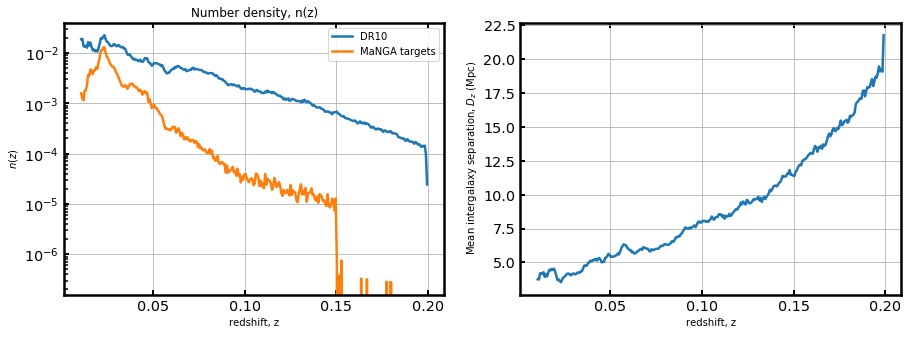

In [3]:
# SDSS DR10 (7966 sq deg) with the redshift limit of z=0.2.
DR10 = fits.open(inpath+'CW_mpl6_yang_s5')[1].data
z_dr10 = DR10['zobs'][(DR10['zobs'] <= 0.2) & (DR10['zobs'] >= 0)]

# Finding redshift range of MaNGA targets only! 
mngtarg_min = min(DR10['zobs'][DR10['ID'] != - 9999])
mngtarg_max = max(DR10['zobs'][DR10['ID'] != - 9999])
# Number of galaxies per redshift bin.
fig,ax = plt.subplots(1,2,figsize=(15,5))
plt.sca(ax[0])
N_z = np.histogram(z_dr10,bins=np.linspace(mngtarg_min,0.2,301))
N_z_manga = np.histogram(DR10['zobs'][DR10['ID'] != - 9999],bins=N_z[1])

#ax[1].plot([np.mean(D_z[:-1]).value,np.mean(D_z[:-1]).value],[0,3500],'k-.')

# Finding the fraction of the sky covered by DR10.
whole_sky_area = 4*np.pi*(180/np.pi)**2 # steradians converted to sq degs.
frac = 7966 / whole_sky_area
# So e.g. volume up to redshift of 0.1
total_vols = frac*Planck15.comoving_volume(N_z[1])
slice_vols = total_vols[1:] - total_vols[:-1]

# So for each redshift slice n = N/V:
number_density = N_z[0] / slice_vols
number_density_manga = N_z_manga[0] / slice_vols

# Now finding the euclidean inter galaxy separation as a function of redshift.
D_z = number_density**(-1/3)

# Finding bin centres
bin_cen = (N_z[1][:-1] + N_z[1][1:])/2
D_z_interpolate = interpolate.interp1d(bin_cen[:-1],D_z[:-1], kind='cubic')
xnew = np.linspace(mngtarg_min,mngtarg_max, num=301, endpoint=True)

ax[0].set_title('Number density, n(z)')
ax[0].plot(bin_cen,number_density.value,label='DR10')
ax[0].plot(bin_cen,number_density_manga.value,label='MaNGA targets')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('redshift, z')
ax[0].set_ylabel(r'$n(z)$')
ax[0].grid()

ax[1].plot(bin_cen[:-1],D_z[:-1],label='Euclidean')
ax[1].set_ylabel(r' Mean intergalaxy separation, $D_z$ (Mpc)')
ax[1].set_xlabel(r'redshift, z')
ax[1].grid()

def get_axis_limits(ax, scale=.9):
    return ax.get_xlim()[1]*scale*0.75, 0.1#ax.get_ylim()[1]*scale

ax[1].annotate('Median = '+str(round(np.median(D_z[:-1]).value,3))+' Mpc\nMean    = '+str(round(np.mean(D_z[:-1]).value,3))+' Mpc', xy=get_axis_limits(ax[1]))
plt.show()

#### Computing normalised distances and adding as additional column.

In [4]:
cw_gz_pipe3d_mpl8['log_dskel_norm'] = cw_gz_pipe3d_mpl8.log_dskel.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))
cw_gz_pipe3d_mpl8['log_dwall_norm'] = cw_gz_pipe3d_mpl8.log_dwall.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))
cw_gz_pipe3d_mpl8['log_dnode_norm'] = cw_gz_pipe3d_mpl8.log_dnode.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))


#### Making galaxy selection

In [5]:
# selecting only mpl8 galaxies.
cw_gz_pipe3d_mpl8_kinpa = cw_gz_pipe3d_mpl8[(cw_gz_pipe3d_mpl8.stel_feature == 0) & (cw_gz_pipe3d_mpl8.halpha_feature == 0) & ((cw_gz_pipe3d_mpl8.stel_qual == 1) | (cw_gz_pipe3d_mpl8.stel_qual == 2)) & ((cw_gz_pipe3d_mpl8.halpha_qual == 1) | (cw_gz_pipe3d_mpl8.halpha_qual == 2))]
# selecting only centrals.
cw_gz_pipe3d_mpl8_cens = cw_gz_pipe3d_mpl8[(cw_gz_pipe3d_mpl8.massive_flag.values == 1) & (cw_gz_pipe3d_mpl8.f_edge.values > 0.6) & (cw_gz_pipe3d_mpl8.halo_mass_stel.values > 0)]

# splitting on morphology.
etgs, S0_Sas, Sb_Sds = knf.morph_breakdown(cw_gz_pipe3d_mpl8_cens)
all_spirals = pd.concat([S0_Sas, Sb_Sds])
all_early = pd.concat([S0_Sas, etgs])

In [11]:
a,b,c,d,e = sbf.return_tabs(cw_gz_pipe3d_mpl8_cens, min_mass=0, max_mass=10**12, mass_col='halo_mass_stel')

a.shape, b.shape, c.shape, d.shape, e.shape

((742, 417), (742, 417), (406, 417), (246, 417), (1290, 417))

# to do :
- construct generalised function which can accept any morphology and split on any mass range (with choice of matched parameter).
- make script of sanity checks : i.e. lambda_R vs epsilon (coloured on Mhalo / Mstel - distance to filaments??).
- individual morphologies plotted on the Mhalo vs lambda_Re plane.

#### Creating Mhalo bin vs lambda_R plot for each morphology bin.
- these plots are made with $\mathrm{D_{skel} < 1.5 Mpc}$.

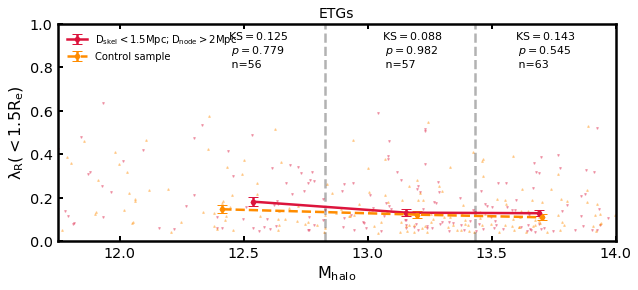

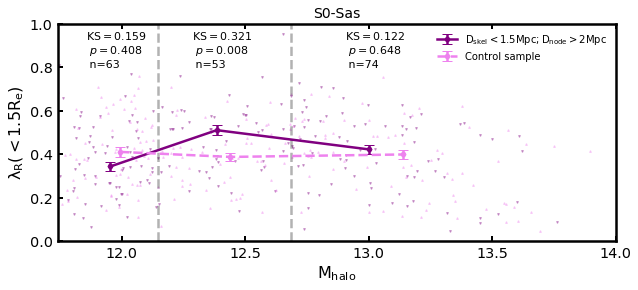

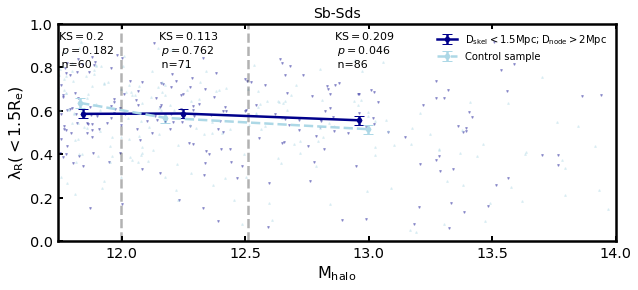

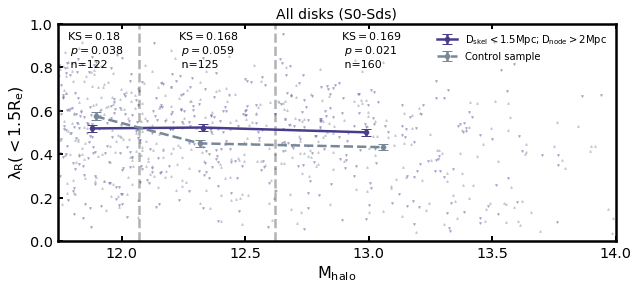

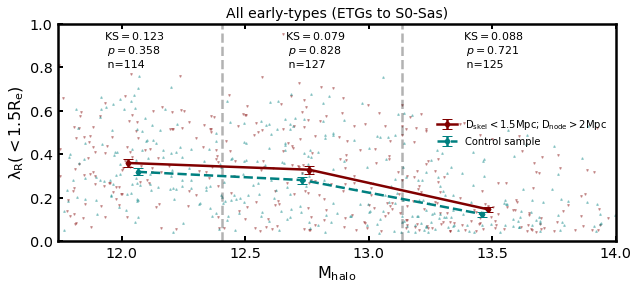

In [97]:
# plotting etgs 
ax = sbf.plot_lambdaR_mhalo(etgs, fil_color='crimson', con_color='darkorange', label='ETGs')
ax.legend(frameon=False, loc='upper left')
plt.savefig(outpath+'etgs_lambdaR_mhalo.pdf', format='pdf', bbox_inches='tight')

# now for lenticulars only.
ax = sbf.plot_lambdaR_mhalo(S0_Sas, fil_color='purple', con_color='violet', label='S0-Sas')
ax.legend(frameon=False, loc='upper right')
plt.savefig(outpath+'S0_Sa_lambdaR_mhalo.pdf', format='pdf', bbox_inches='tight')

# now for spirals only.
ax = sbf.plot_lambdaR_mhalo(Sb_Sds, fil_color='darkblue', con_color='lightblue', label='Sb-Sds')
ax.legend(frameon=False, loc='upper right')
plt.savefig(outpath+'Sb_Sd_lambdaR_mhalo.pdf', format='pdf', bbox_inches='tight')

# considering for everything with a disc
ax = sbf.plot_lambdaR_mhalo(all_spirals, fil_color='darkslateblue', con_color='lightslategrey', label='All disks (S0-Sds)')
ax.legend(frameon=False, loc='upper right')
plt.savefig(outpath+'all_late_lambdaR_mhalo.pdf', format='pdf', bbox_inches='tight')

# considering everything with a bulge of some sort.
ax = sbf.plot_lambdaR_mhalo(all_early, fil_color='maroon', con_color='teal', label='All early-types (ETGs to S0-Sas)')
ax.legend(frameon=False, loc='center right')
plt.savefig(outpath+'all_early_lambdaR_mhalo.pdf', format='pdf', bbox_inches='tight')


#### Creating diagnostic plots which compare properties for the filament vs control samples.
- Starting with Mstel

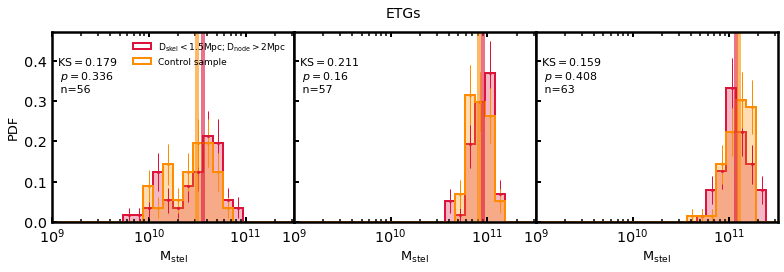

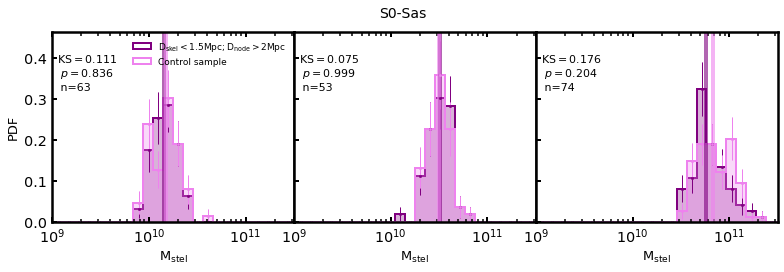

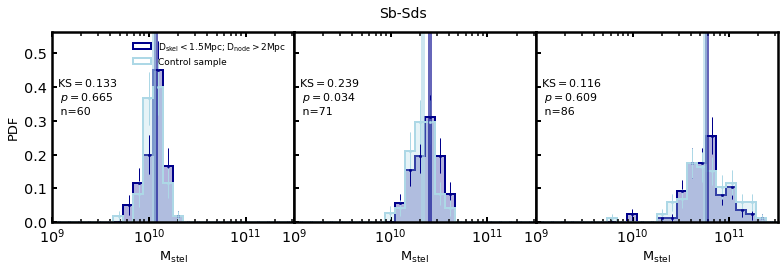

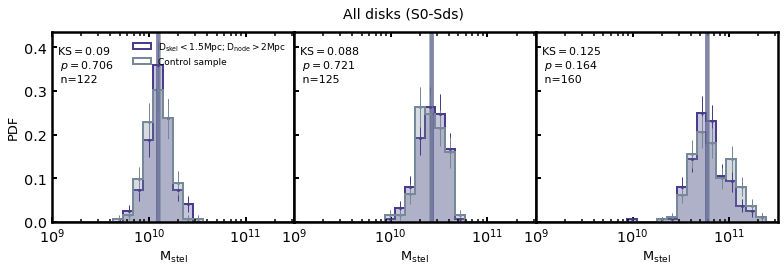

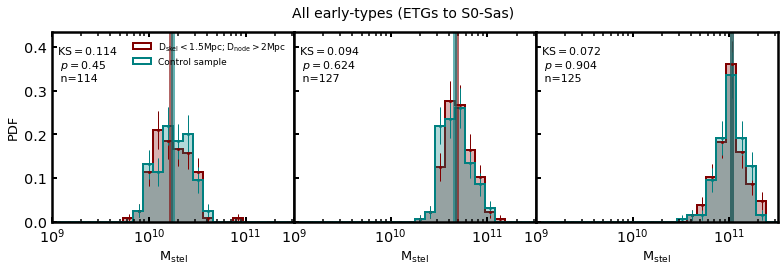

In [101]:
# plotting etgs 
ax = sbf.plot_mstel_comparison(etgs, fil_color='crimson', con_color='darkorange', label='ETGs')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'etgs_mstel_control_comparison.pdf', format='pdf', bbox_inches='tight')

# now for lenticulars only
ax = sbf.plot_mstel_comparison(S0_Sas, fil_color='purple', con_color='violet', label='S0-Sas')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'S0_Sa_mstel_control_comparison.pdf', format='pdf', bbox_inches='tight')

# now for spirals only.
ax = sbf.plot_mstel_comparison(Sb_Sds, fil_color='darkblue', con_color='lightblue', label='Sb-Sds')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'Sb_Sd_mstel_control_comparison.pdf', format='pdf', bbox_inches='tight')

# considering for everything with a disc
ax = sbf.plot_mstel_comparison(all_spirals, fil_color='darkslateblue', con_color='lightslategrey', label='All disks (S0-Sds)')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'all_late_mstel_control_comparison.pdf', format='pdf', bbox_inches='tight')

# considering everything with a bulge of some sort.
ax = sbf.plot_mstel_comparison(all_early, fil_color='maroon', con_color='teal', label='All early-types (ETGs to S0-Sas)')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'all_early_mstel_control_comparison.pdf', format='pdf', bbox_inches='tight')


#### Creating diagnostic comparison plot for Mhalo

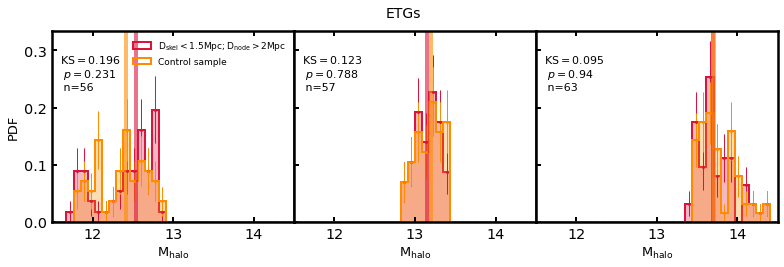

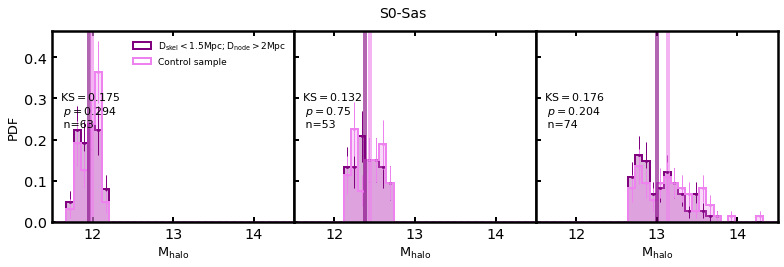

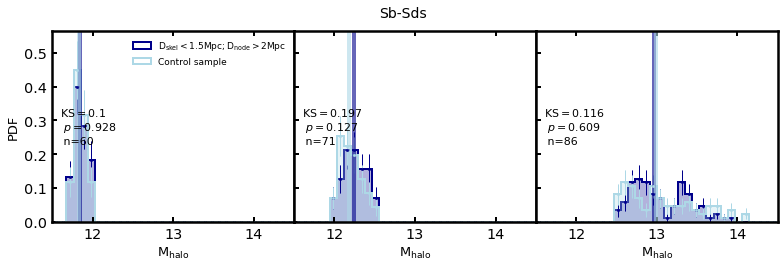

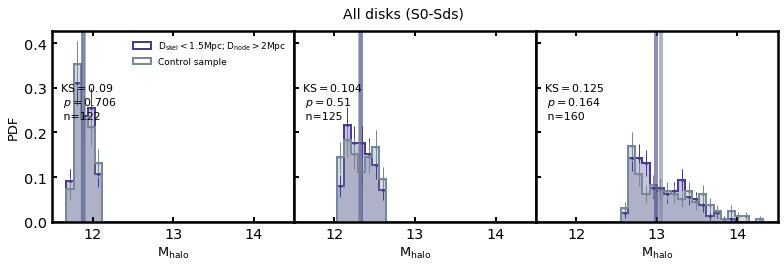

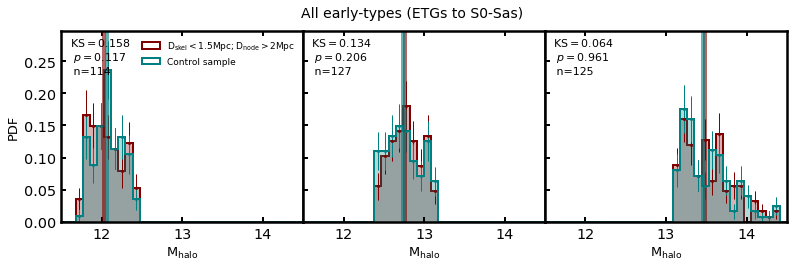

In [109]:
# plotting etgs 
ax = sbf.plot_mhalo_comparison(etgs, fil_color='crimson', con_color='darkorange', label='ETGs')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'etgs_mhalo_control_comparison.pdf', format='pdf', bbox_inches='tight')

# now for lenticulars only
ax = sbf.plot_mhalo_comparison(S0_Sas, fil_color='purple', con_color='violet', label='S0-Sas')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'S0_Sa_mhalo_control_comparison.pdf', format='pdf', bbox_inches='tight')

# now for spirals only.
ax = sbf.plot_mhalo_comparison(Sb_Sds, fil_color='darkblue', con_color='lightblue', label='Sb-Sds')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'Sb_Sd_mhalo_control_comparison.pdf', format='pdf', bbox_inches='tight')

# considering for everything with a disc
ax = sbf.plot_mhalo_comparison(all_spirals, fil_color='darkslateblue', con_color='lightslategrey', label='All disks (S0-Sds)')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'all_late_mhalo_control_comparison.pdf', format='pdf', bbox_inches='tight')

# considering everything with a bulge of some sort.
ax = sbf.plot_mhalo_comparison(all_early, fil_color='maroon', con_color='teal', label='All early-types (ETGs to S0-Sas)')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'all_early_mhalo_control_comparison.pdf', format='pdf', bbox_inches='tight')


#### Creating diagnostic plot for $\mathrm{\rho_{3Mpc}}$

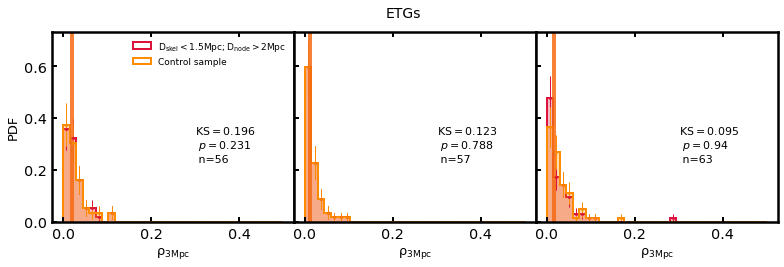

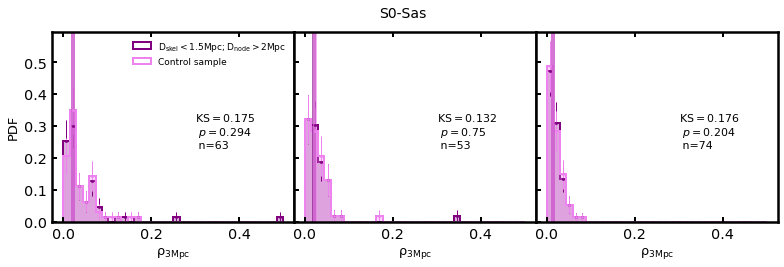

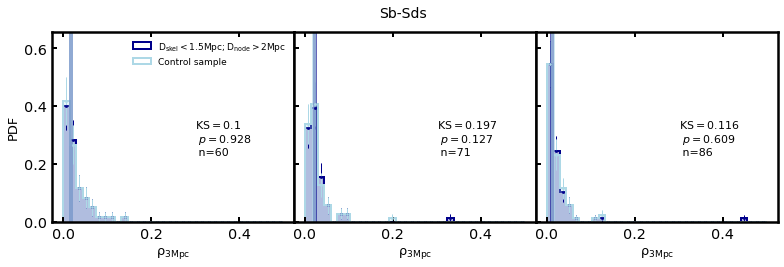

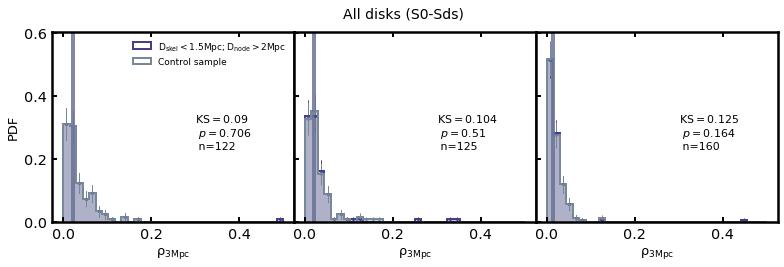

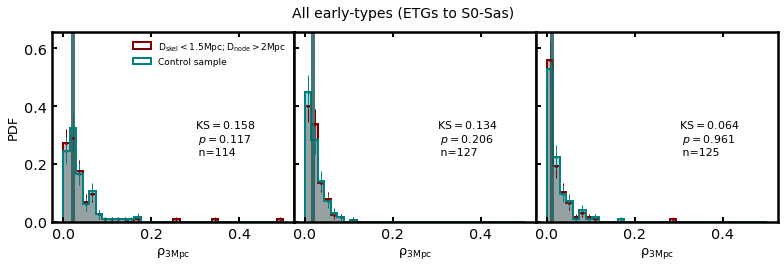

In [132]:
ax = sbf.plot_dtfe_comparison(etgs, fil_color='crimson', con_color='darkorange', label='ETGs')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'etgs_rho3Mpc_control_comparison.pdf', format='pdf', bbox_inches='tight')

ax = sbf.plot_dtfe_comparison(S0_Sas, fil_color='purple', con_color='violet', label='S0-Sas')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'S0_Sa_rho3Mpc_control_comparison.pdf', format='pdf', bbox_inches='tight')

ax = sbf.plot_dtfe_comparison(Sb_Sds, fil_color='darkblue', con_color='lightblue', label='Sb-Sds')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'Sb_Sd_rho3Mpc_control_comparison.pdf', format='pdf', bbox_inches='tight')

ax = sbf.plot_dtfe_comparison(all_spirals, fil_color='darkslateblue', con_color='lightslategrey', label='All disks (S0-Sds)')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'all_late_rho3Mpc_control_comparison.pdf', format='pdf', bbox_inches='tight')

ax = sbf.plot_dtfe_comparison(all_early, fil_color='maroon', con_color='teal', label='All early-types (ETGs to S0-Sas)')
ax[0].legend(frameon=False, loc='upper right', fontsize=9)
plt.savefig(outpath+'all_early_rho3Mpc_control_comparison.pdf', format='pdf', bbox_inches='tight')
